# [DM 2025/26] Hyperparameter Tuning

🎛️ Hyperparameter tuning is a crucial step of the Data Mining elaboration workflow, it consists on searching the best hyperparameters combinations for a given model. This search can be exhaustive and test all the possibile combinations of the specified hyperparameters, in this case it is called **Grid Search**; the problem of this approac is that these combinations can possibly be a huge number and the search would require much time.

🎲 Since our aim is demostrative and we can be satisfied to test a reasonable amount of possible combinations even without being fully exhaustive, we choose **Random Search** as hyperparameter tuning technique.

❌ To run this approach we need to specify a number of iterations that will be equal to the number of combinations that will be randomly sampled by the hyperparameters space we spacify (the larger the number of iterations, the highest the probability to detect a combination among the best ones). For each iteration, a **Cross Validation** is performed.

At the end of this process we can be reasonably sure that the found hyperparameters will guarantee a good performance to our models, or at least better than $n$ other possible choiches with $n$ being the number of iterations.

In [5]:
# Utilities
import pandas as pd
import json
import numpy as np

# ML
from sklearn.model_selection import RandomizedSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt

Here we specify the parameters for the validation phase

In [6]:
RANDOM_SEED = 42				# Random seed to allow reproducibility of our experiments
N_SEARCH_ITERATIONS = 75		# Number of search iterations
N_CROSS_VALIDATION_FOLDS = 5	# Number of folds for cross-validation
SCORING = ["accuracy", "f1"]	# Metrics to compare to choose the best combination of hyperparameters

📏 For each model, we specify a couple of hyperparameters to tune and for each of these, we select a variation range where we want the research to be performed. This range is arbitrary and it should require a dynamical tuning itself, but since our purpose is purely demonstrative, we will use some static and unoptimized ranges.

In [7]:
model_search = {
    "DecisionTree": {
        "instance": DecisionTreeClassifier(random_state=RANDOM_SEED),
        "hyperparameters": {
            "max_depth": list(range(1, 50)) + [None],
            "criterion": ["gini", "entropy", "log_loss"]
		}
	},
    "NaiveBayes": {
        "instance": GaussianNB(),
        "hyperparameters": {}
	},
    "KNN": {
        "instance": KNeighborsClassifier(),
        "hyperparameters": {
            "n_neighbors": range(1, 15),
            "metric": ["euclidean", "cosine", "minkowski"]
		}
	},
	"SVC": {
		"instance": SVC(random_state=RANDOM_SEED),
		"hyperparameters": {
			"kernel": ["linear", "rbf"],
			"C": [0.1, 1, 10, 100],
			"gamma": ["scale", 0.01, 0.1, 1]
		}
	},
    "MLP": {
        "instance": MLPClassifier(random_state=RANDOM_SEED),
        "hyperparameters": {
            "hidden_layer_sizes": range(1, 50),
            "learning_rate": ["constant", "invscaling", "adaptive"]
		}
	},
    "RandomForest": {
        "instance": RandomForestClassifier(random_state=RANDOM_SEED),
        "hyperparameters": {
            "n_estimators": range(100, 200),
            "max_depth": list(range(1, 50)) + [None],
            "criterion": ["gini", "entropy", "log_loss"]
		}
	},
    "AdaBoost": {
        "instance": AdaBoostClassifier(random_state=RANDOM_SEED),
        "hyperparameters": {
            "n_estimators": range(100, 200)
		}
	},
    "XGBoost": {
        "instance": XGBClassifier(),
        "hyperparameters": {
            "n_estimators": range(50, 200),
            "max_depth": list(range(1, 50)) + [None],
		}
	}
    
}

Here we perform a cross validation so we need the training data, we retreive it from the data folder that we populated when running the **main** notebook.

In [ ]:
# Import of original datasets

X_train = pd.read_csv("data/X_train.csv")
y_train = pd.read_csv("data/y_train.csv")

np.unique_counts(y_train)

UniqueCountsResult(values=array([0, 1]), counts=array([2863, 1190]))

In [ ]:
# Import of datasets after undersampling

X_train_under = pd.read_csv("data/X_train_under.csv", sep=",")
y_train_under = pd.read_csv("data/y_train_under.csv", sep=",")

np.unique_counts(y_train_under)

UniqueCountsResult(values=array([0, 1]), counts=array([1190, 1190]))

In [ ]:
# Import of datasets after oversampling

X_train_over = pd.read_csv("data/X_train_over.csv")
y_train_over = pd.read_csv("data/y_train_over.csv")

np.unique_counts(y_train_over)

UniqueCountsResult(values=array([0, 1]), counts=array([2863, 2908]))

▶️ At this stage we are ready to start the tuning process.

<span style="color:yellow;">[WARNING] Running this cell will require about 1 hour for 75 iterations! </span>

We already run it and saved the results in `tuned_hyperparameters.json` so that they can be used in the **main** notebook and there is no need to run it again.

In [ ]:
tuned_models = {}

for sampling in ("over", "under", "none"):
	data = X_train
	labels = y_train
	if sampling == "under":
		data = X_train_under
		labels = y_train_under
	elif sampling == "over":
		data = X_train_over
		labels = y_train_over

	tuned_models[sampling] = {}

	for model in model_search:
		random_search = RandomizedSearchCV(
			estimator=model_search[model].get("instance"),
			param_distributions=model_search[model].get("hyperparameters"),
			n_iter=N_SEARCH_ITERATIONS,
			scoring=SCORING,
			refit=SCORING[1],			# This metric is the one that is maximized with the parameters returned by the search (we choose F1-score to manage the imbalanced dataset)	
			cv=N_CROSS_VALIDATION_FOLDS,
			random_state=RANDOM_SEED
		)

		res = random_search.fit(data, labels)
		res.best_params_, res.best_score_
		print(f"Hyperparameters for {model} selected!")

		tuned_models[sampling][model] = {"params": res.best_params_, 
								   		"accuracy": res.cv_results_["mean_test_accuracy"][0],
								   		"f1": res.cv_results_["mean_test_f1"][0]}

		with open("tuned_hyperparameters_no.json", mode="w") as file:
			json.dump(tuned_models, file, indent=4)

📊 Once we obtain the hyperparameters, we render three plots, one for each balancing setup. For each plot, each barplot is referred to a model and shows the accuracy and the F1-score that that model reached in the validation phase

In [ ]:
with open("./tuned_hyperparameters.json", mode="r") as file:
    hyperparameters = json.load(file)

cv_results = []
for strategy in hyperparameters.keys():
    for model_name, model_data in hyperparameters[strategy].items():
        cv_results.append({
            'Model': model_name,
            'Strategy': strategy,
            'Accuracy': model_data['accuracy'],
            'F1': model_data['f1']
        })

cv_df = pd.DataFrame(cv_results)

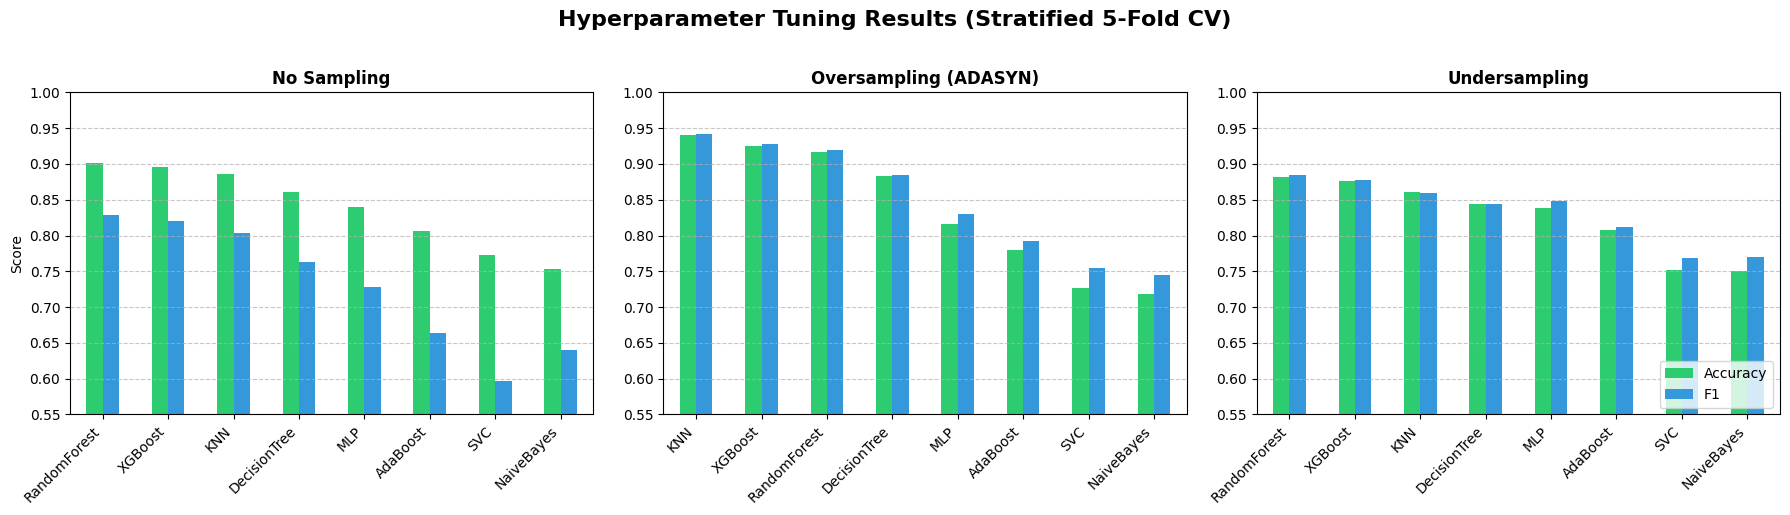

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Hyperparameter Tuning Results (Stratified 5-Fold CV)', fontsize=16, fontweight='bold', y=1.02)

strategies = ['none', 'over', 'under']
strategy_titles = {'none': 'No Sampling', 'over': 'Oversampling (ADASYN)', 'under': 'Undersampling'}

for idx, strategy in enumerate(strategies):
    ax = axes[idx]
    
    df_strategy = cv_df[cv_df["Strategy"] == strategy].copy()
    df_strategy = df_strategy.set_index("Model")[["Accuracy", "F1"]]
    df_strategy = df_strategy.sort_values("Accuracy", ascending=False)
    
    df_strategy.plot.bar(ax=ax, color=['#2ecc71', '#3498db'], legend=False)
    
    ax.set_title(strategy_titles[strategy], fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Score' if idx == 0 else '')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylim(0.55, 1.0)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    if idx == 2:
        ax.legend(['Accuracy', 'F1'], loc='lower right')

plt.tight_layout()
plt.show()